In [1]:
import random
from intervaltree import IntervalTree, Interval
from typing import Optional
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from copy import deepcopy
import numpy as np
import pandas as pd

In [2]:
random.seed(42)
N = 8
hours_active = 24
route_len = 90
change_time = 15
pop_size = 100
hours_daily = 8
hours_shift = 12
peak_amount = 5
nonpeak_amount=3
race_per_week_min, race_per_week_max = 10,200
def amount_at_hour(time):
    time%=24*60
    if time < 8*60 or time > 21*60:
        return 1
    if 7*60<=time<9*60 or 18*60<=time<20*60:
        return peak_amount
    else:
        return nonpeak_amount
    
def amount_at_hour(time): # переопределена: 1 ночью, 5 днём, 3 в выходные
    day_time=time%24*60
    if day_time < 8*60 or day_time > 20*60:
        return 1
    elif time>=24*60*5:
        return nonpeak_amount
    else:
        return peak_amount

In [3]:
def intervals_for_daily(time_begin):
    n = int(hours_daily//(route_len/60))
    r_len= route_len
    time = time_begin+r_len
    intervals = [(time_begin,time-1)]
    fl=True
    for i in range(n-1):
        if 13<=(time/60)%24<=15 and fl:
            fl=False
            time+=60
        intervals.append((time,time+r_len-1))
        time+=r_len
    if fl:
        print("ERROR: COULD NOT FIND A BREAK TIME FOR TIME:", time_begin)
    return intervals

def intervals_for_shift(time_begin):
    n = int(hours_shift//(route_len/60))
    r_len= route_len
    time = time_begin+r_len
    intervals = [(time_begin,time-1)]
    fl=False
    for i in range(n-1):
        if fl:
            fl=False
            time+=2
        else:
            fl=True
        intervals.append((time,time+r_len-1))
        time+=r_len
    return intervals

In [4]:
class Driver():
    def __init__(self, dr_type:int, dr_id:int):
        self.dr_type = dr_type # 1 дневной 0 сменный
        self.id=dr_id
        self.last_driven = []
        routes_per_day = hours_daily if dr_type else hours_shift
        self.routes_per_day = int(routes_per_day//(route_len/60))
        self.total_time = 102*5 if dr_type else 150*5
        self.dr_schedule = []

    def check_avaible(self, time):
        if len(self.last_driven)==0:
                return True
        if self.dr_type==0:
            if self.last_driven[-1] + 2*24*60 <= time: # 2 дня перерыва
                return True
            else: return False
        # if time>1440:
        #     return False
        if len(self.last_driven)==0:
            return True
        if self.last_driven[-1]//1440 < time//1440:
            return True
        return False

class Bus_schedule():
    _id = 0
    def __init__(self):
        self.schedule: IntervalTree = IntervalTree()
        self.id = Bus_schedule._id
        Bus_schedule._id+=1

    def interval_checker(self, begin, driver: Driver):
        inter_arr:list[tuple[int,int]]=[]
        if driver.dr_type:
            inter_arr = intervals_for_daily(begin)
        else:
            inter_arr = intervals_for_shift(begin)
        for begin, end in inter_arr:
            if begin>(7*24*60):
                self.schedule.addi(begin%(7*24*60),end%(7*24*60),f"{driver.id}.{driver.dr_type}")
            elif end>(7*24*60):
                self.schedule.addi(begin,end,f"{driver.id}.{driver.dr_type}")
                self.schedule.addi(0,end%(7*24*60),f"{driver.id}.{driver.dr_type}")
            else:
                self.schedule.addi(begin,end,f"{driver.id}.{driver.dr_type}")


class Schedule():
    _id_counter = 0
    def __init__(self,buses: Optional[list[Bus_schedule]] = None, shift_chance: Optional[float]=None):
        self.buses:list[Bus_schedule] = []
        if buses is None:
            self.buses = [Bus_schedule() for i in range(N)]
        else:
            self.buses = buses
        self.score = 1
        self.drivers = 1000
        self.estimated1 = False
        self.estimated2 = False
        self.id = Schedule._id_counter
        Schedule._id_counter+=1
        self.marked_buses: list[Bus_schedule] = [Bus_schedule() for i in range(N)]
        self.dr_prev_week = 0
        self.driver_list: list[Driver] = []
        self.shift_chance=random.uniform(0.2, 0.8) if shift_chance is None else shift_chance

    def __eq__(self, other: 'Schedule'):
        if not isinstance(other, Schedule):
            return NotImplemented
        return self.id == other.id
    
    def __ne__(self, other):
        return not self.__eq__(other)

    def estimate1(self):
        if self.estimated1:
            return
        self.score = 100000*5
        self.estimated1=True
        test=0
        for i in self.buses:
            test+=len(i.schedule)
        all_buses = IntervalTree()
        for bus in self.buses:
            all_buses |= bus.schedule
        if test!=len(all_buses):
            print("something wrong")
            print("test =",test,"union =",len(all_buses))
        for i in range(10080):
            amount_now = len(all_buses[i])
            amount_best = amount_at_hour(i)
            if amount_now==0:
                self.score-=100
            # elif amount_now < amount_best:
            #     self.score-=10*(amount_best-amount_now)
            # elif amount_now>amount_best:
            #     self.score-=5*(amount_now-amount_best)
            else:
                self.score-=5*(amount_best-amount_now)**2
        # print(self.score, end=" ")
    
    def estimate2(self):
        if self.estimated2:
            return
        if not self.estimated1:
            self.estimate1()
        self.estimated2=True
        self.drivers=0
        self.marked_buses = [Bus_schedule() for i in range(len(self.buses))]
        self.driver_list=[]
        r_len= route_len
        for i in range(10080):
            for j in range(len(self.buses)):
                t = list(self.buses[j].schedule.envelop(i,i+r_len-1))
                if len(t)==0: continue
                if (t[0].end - t[0].begin) != r_len - 1:
                    continue
                dr_t, beg, bus_id = list(t)[0].data.split(".")
                dr_t=int(dr_t)
                beg=int(beg)
                if not beg: continue
                new = False
                if len(self.driver_list)>0:
                    for dr in self.driver_list:
                        if dr.dr_type==dr_t and dr.check_avaible(i):
                            self.marked_buses[j].interval_checker(i, dr)
                            dr.last_driven.append(i+dr.total_time-1)
                            dr.dr_schedule.append((i,i+dr.total_time-1))
                            break
                    else: 
                        new = True
                else:
                    new = True
                if new:
                    dr = Driver(dr_type=dr_t,dr_id=self.drivers+1)
                    self.drivers+=1
                    self.driver_list.append(dr)
                    self.marked_buses[j].interval_checker(i, dr)
                    dr.last_driven.append(i+dr.total_time-1)
                    dr.dr_schedule.append((i,i+dr.total_time-1))

In [5]:
def check_bus(bus: Bus_schedule, time_begin, time_end):
    if len(bus.schedule[time_begin - change_time:time_end+change_time-1])==0:
        if time_end+change_time-1>7*24*60 and len(bus.schedule[0:(time_end+change_time-1)%(7*24*60)])>0:
            return False
        return True
    return False


def gen_bus(bus:Bus_schedule, shift_chance=0.333):
    dr_type = 1 if random.random()>shift_chance else 0
    if dr_type: # дневной
        day = random.randint(0,4)
        begin = day*1440 + random.randint(7*60, 12*60) # от 7:00 до 12:00
        total_time = 510
        if check_bus(bus, begin, begin+total_time):
            inter = intervals_for_daily(begin)
        else:
            for _ in range(5):
                day = random.randint(0,4)
                begin = day*1440 + random.randint(7*60, 12*60)
                if check_bus(bus, begin, begin+total_time):
                    inter = intervals_for_daily(begin)
                    break
            else: return
    else: # сменный
        begin = random.randint(0,10080-1)
        total_time = 750
        if check_bus(bus, begin, begin+total_time):
            inter = intervals_for_shift(begin)
        else:
            for _ in range(5):
                begin = random.randint(0,10080-1)
                if check_bus(bus, begin, begin+total_time):
                    inter = intervals_for_shift(begin)
                    break
            else: return
    fl = 1
    for i in inter:
        if i[0]>(7*24*60):
            bus.schedule[i[0]%(7*24*60):i[1]%(7*24*60)]=f"{dr_type}.{fl}.{bus.id}"
        elif i[1]>(7*24*60):
            bus.schedule[i[0]:i[1]]=f"{dr_type}.{fl}.{bus.id}"
            bus.schedule[0:i[1]%(7*24*60)]=f"{dr_type}.{fl}.{bus.id}"
        else:
            bus.schedule[i[0]:i[1]]=f"{dr_type}.{fl}.{bus.id}"
        if fl:
            fl=0

def gen_pop(population:list[Schedule], shift_chance=0.333):
    for sched in population:
        races = random.randint(race_per_week_min,race_per_week_max)
        for _ in range(races):
            bus = sched.buses[random.randint(0, len(sched.buses)-1)]
            gen_bus(bus, sched.shift_chance)
            
                    

In [6]:
def crossover(sch1: Schedule, sch2:Schedule):
    child1,child2 = Schedule(deepcopy(sch1.buses)),Schedule(deepcopy(sch2.buses))
    for i in range(N):
        if random.getrandbits(1):
            child1.buses[i], child2.buses[i] = deepcopy(child2.buses[i]), deepcopy(child1.buses[i]) # random swap
    return child1, child2

def mutation(sch: Schedule):
    mutated_sch = Schedule(sch.buses, sch.shift_chance)
    id = random.randint(0, len(mutated_sch.buses)-1)
    mutated_sch.buses[id] = Bus_schedule()
    gen_bus(mutated_sch.buses[id], mutated_sch.shift_chance)
    return mutated_sch   

def selection(old_pop:list[Schedule], best_schedule_per_iter:list[Schedule]):
    pop_size = len(old_pop)
    for sch in old_pop:
        sch.estimate1()
        print(sch.score,end=" ")
    print()
    old_pop = [sch for sch in old_pop if sch.score >= 0]
    old_pop.sort(key=lambda x: x.score,reverse=True)
    temp_pop = old_pop[:min(pop_size//2,len(old_pop))]
    best_sch = temp_pop[:min(pop_size//10,len(temp_pop))] # 10%
    for i in best_sch:
        i.estimate2()
    best_sch.sort(key=lambda x: x.drivers)
    best_sch = best_sch[:min(pop_size//20,len(best_sch))] # 5%
    if len(best_sch)>0:
        best_schedule_per_iter.append(best_sch[0])
    else:
        print("no best on this iter!")
    if len(temp_pop)*2<pop_size:
        while len(temp_pop)*2<pop_size:
            t = Schedule()
            races = random.randint(race_per_week_min,race_per_week_max)
            for _ in range(races):
                bus = t.buses[random.randint(0, len(t.buses)-1)]
                gen_bus(bus, t.shift_chance)
            temp_pop.append(t)
    new_pop = deepcopy(best_sch)
    for parent1 in best_sch:
        parent2 = random.choice(old_pop)
        while parent2 == parent1:
            parent2 = random.choice(old_pop)
        child1, child2 = crossover(parent1, parent2)
        new_pop.extend([child1, child2])
    while len(new_pop)<0.85*pop_size:
        parent1 = random.choice(old_pop)
        parent2 = random.choice(old_pop)
        while parent2 == parent1:
            parent2 = random.choice(old_pop)
        child1, child2 = crossover(parent1, parent2)
        new_pop.extend([child1, child2])
    while len(new_pop)<pop_size:
            t = Schedule()
            races = random.randint(race_per_week_min,race_per_week_max)
            for _ in range(races):
                bus = t.buses[random.randint(0, len(t.buses)-1)]
                gen_bus(bus,t.shift_chance)
            new_pop.append(t)
    return new_pop[:pop_size]


def evolution(population:list[Schedule], gen_limit:int=100_000, mutate_chance:float=0.05):
    best_schedule_per_iter:list[Schedule]=[Schedule()]
    last_change=0
    last_score = 0
    last_drivers=9999
    for i in range(gen_limit):
        if i%1==0 and i>0: print("Current generation:", i,"best_res_score:",best_schedule_per_iter[-1].score, "best_res_drivers:",best_schedule_per_iter[-1].drivers)
        population = selection(population, best_schedule_per_iter)
        population=[i if random.random()>mutate_chance else mutation(i) for i in population]
        if best_schedule_per_iter[-1].score!=last_score or best_schedule_per_iter[-1].drivers!=last_drivers:
            last_score=best_schedule_per_iter[-1].score
            last_drivers = best_schedule_per_iter[-1].drivers
            last_change = i
        if last_change+100<=i: # 100 итераций без изменений - break
            break
    return best_schedule_per_iter

In [7]:
population = [Schedule() for i in range(pop_size)]
gen_pop(population)
print("starting evolution...")
best_schedules = evolution(population)

starting evolution...
-73650 47130 143550 31605 38475 -232015 239790 49090 180600 -87710 32750 145630 55085 8105 215160 36120 87330 25300 219320 115385 187515 193950 104120 49885 262295 134915 -308275 -97885 79075 151485 42150 210325 51810 101220 -13585 152875 216785 30175 112615 65835 -18440 39330 82740 -138050 108665 186560 127565 -67385 133145 145820 66985 -164710 79575 -58755 127270 -264015 95785 126995 60085 19875 -2925 -90735 65240 23720 175495 -39710 110705 56035 84565 77205 1090 56935 122615 17925 -26850 110775 203650 144165 -45745 32450 -19045 144040 27270 49000 80620 58030 8255 122495 16265 -103505 -104185 125185 55770 -19820 55090 53330 -29310 166140 108195 224560 
Current generation: 1 best_res_score: 219320 best_res_drivers: 14
219320 210325 196040 187515 262295 225535 153735 71885 189940 193170 156100 213095 71350 144355 206045 68485 36080 159455 114530 56420 -11220 90620 117280 64605 157300 104040 83810 209855 174650 213495 140535 115685 121020 44450 50025 154410 136300 

In [9]:
def display_multiple_interval_trees_and_get_drivers(trees):
    day_labels=['ПН','ВТ','СР','ЧТ','ПТ','СБ','ВС']
    minutes_in_day = 288*5
    hours_in_day = 24
    x = np.arange(0, 2016*5)
    tick_positions_days = np.arange(0, len(x), minutes_in_day)  # Метки дней (каждые 288 точек)
    tick_positions_hours = np.arange(0, len(x), minutes_in_day // hours_in_day)  # Метки часов (каждые 12 точек)
    trees = trees.marked_buses
    fig, ax = plt.subplots(figsize=(16, len(trees)))

    existing_colors = list(plt.cm.tab20.colors)
    additional_colors = [
        (0.6, 0.1, 0.8),
        (0.2, 0.5, 0.9), 
        (0.9, 0.3, 0.1) 
    ]
    colors = existing_colors + additional_colors
    
    labels = set()

    for line_idx, tree in enumerate(trees):
        tree = tree.schedule
        intervals = list(tree)
        intervals.sort(key=lambda x: (x.begin, x.end))

        for i, iv in enumerate(intervals):
            id_type = iv.data.split(".")
            color = colors[int(id_type[0]) % len(colors)]
            label = f"{id_type[0]} - {"дневной" if id_type[1]=="1" else "сменный"}"
            labels.add((color,label))
            face_color = colors[int(id_type[0]) % len(colors)]
            edge_color = "black"

            ax.plot(
                [iv.begin, iv.end],
                [line_idx, line_idx],
                lw=6, color=face_color, solid_capstyle='butt', zorder=2
            )
            ax.plot(
                [iv.begin, iv.end],
                [line_idx, line_idx],
                lw=6.5, color=edge_color, solid_capstyle='butt', zorder=1
            )

    ax.set_yticks(range(len(trees)))
    ax.set_yticklabels([f"Автобус №{i+1}" for i in range(len(trees))])
    ax.set_xlabel("День, время")
    ax.set_title("Расписание автобусов на неделю")
    ax.set_xlim(0,2016)
    ax.set_xticks(tick_positions_days)  # Основные метки для дней
    ax.set_xticklabels(day_labels[:len(tick_positions_days)], fontsize=12, fontweight='bold')
    ax.set_xticks(tick_positions_hours, minor=True)  # Минорные метки для часов
    ax.tick_params(axis='x', which='major', length=10, width=2, color='black')
    ax.tick_params(axis='x', which='minor', length=5, width=1, color='gray', labelsize=8)

    plt.tight_layout()
    plt.grid(axis="x")
    handles = []
    labels=sorted(list(labels),key= lambda x: int(x[1].split(" - ")[0]))
    
    for color, label in labels:
        handles.append(plt.Line2D([], [], color=color, lw=6, label=label))

    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1), title="№ водителя")
    plt.show()

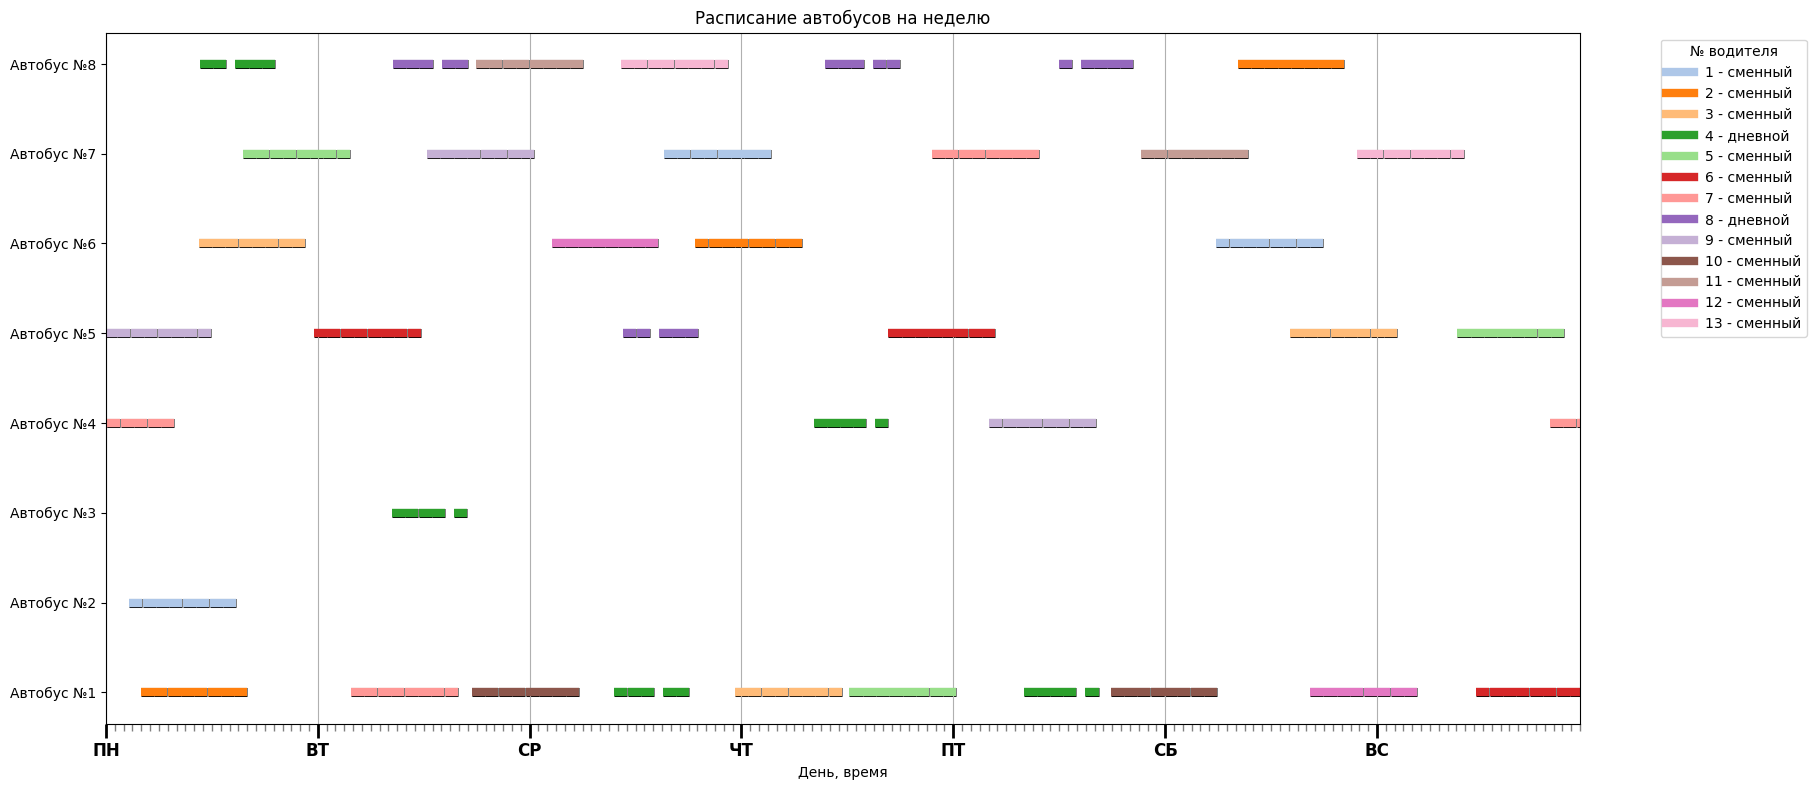

In [14]:
best_schedule = sorted(best_schedules,key=lambda x:(-x.score, x.drivers))[0]
display_multiple_interval_trees_and_get_drivers(best_schedule)

In [16]:
def first_null(i):
    if i<10:
        return "0"+str(i)
    else: return i

def display_drivers(drivers:list[Driver]):
    days = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
    rows = []
    for idx, dr in enumerate(drivers):
        row = {"№": f"Водитель {idx + 1}"}
        if dr.dr_type:
            row["Тип"] = "Дневной"
        else:
            row["Тип"] = "Сменный"
        for start, end in dr.dr_schedule:
            day = days[start//1440] 
            if day not in row:
                row[day] = []
            row[day].append((start, end))
        for day in row:
            if isinstance(row[day], list):
                row[day] = ", ".join([f"{first_null((s%1440)//60)}:{first_null(s%60)}-{first_null((e%1440)//60)}:{first_null(e%60)}" for s, e in row[day]])
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df[['№', 'Тип', "Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]]
    df = df.fillna("")
    return df

In [17]:
display_drivers(best_schedule.driver_list)

,№,Тип,Понедельник,Вторник,Среда,Четверг,Пятница,Суббота,Воскресенье
0,Водитель 1,Сменный,02:39-15:08,,15:14-03:43,,,05:48-18:17,
1,Водитель 2,Сменный,03:57-16:26,,18:46-07:15,,,08:13-20:42,
2,Водитель 3,Сменный,10:29-22:58,,23:16-11:45,,,14:12-02:41,
3,Водитель 4,Дневной,10:40-19:09,08:25-16:54,09:36-18:05,08:10-16:39,07:58-16:27,,
4,Водитель 5,Сменный,15:32-04:01,,,12:14-00:43,,,09:07-21:36
5,Водитель 6,Сменный,23:34-12:03,,,16:39-05:08,,,11:15-23:44
6,Водитель 7,Сменный,,03:46-16:15,,21:36-10:05,,,19:37-08:06
7,Водитель 8,Дневной,,08:31-17:00,10:37-19:06,09:26-17:55,11:55-20:24,,
8,Водитель 9,Сменный,,12:24-00:53,,,04:05-16:34,,23:47-12:16
9,Водитель 10,Сменный,,17:29-05:58,,,17:49-06:18,,


In [18]:
best_schedule.score

293910

In [20]:
manual_buses = [Bus_schedule() for i in range(N)]
for i in range(0,3):
    for day in range(0,5):
        inter = intervals_for_daily(10*60+day*60*24)
        fl = 1
        for beg,end in inter:
            manual_buses[i].schedule[beg:end]=f"{1}.{fl}.{manual_buses[i].id}"
            if fl:
                fl=0
for i in range(3,5):
    for day in range(0,5):
        inter = intervals_for_daily(11*60+day*60*24)
        fl = 1
        for beg,end in inter:
            manual_buses[i].schedule[beg:end]=f"{1}.{fl}.{manual_buses[i].id}"
            if fl:
                fl=0
for day in range(0,7):
    inter = intervals_for_shift(18*60+30+day*60*24)
    fl = 1
    for beg,end in inter:
        if beg>(7*24*60):
            manual_buses[5].schedule[beg%(7*24*60):end%(7*24*60)]=f"{0}.{fl}.{manual_buses[5].id}"
        elif end>(7*24*60):
            manual_buses[5].schedule[beg:end]=f"{0}.{fl}.{manual_buses[5].id}"
            manual_buses[5].schedule[0:end%(7*24*60)]=f"{0}.{fl}.{manual_buses[5].id}"
        else:
            manual_buses[5].schedule[beg:end]=f"{0}.{fl}.{manual_buses[5].id}"
        if fl:
            fl=0
for day in range(0,7):
    inter = intervals_for_shift(21*60+30+day*60*24)
    fl = 1
    for beg,end in inter:
        if beg>(7*24*60):
            manual_buses[6].schedule[beg%(7*24*60):end%(7*24*60)]=f"{0}.{fl}.{manual_buses[6].id}"
        elif end>(7*24*60):
            manual_buses[6].schedule[beg:end]=f"{0}.{fl}.{manual_buses[6].id}"
            manual_buses[6].schedule[0:end%(7*24*60)]=f"{0}.{fl}.{manual_buses[6].id}"
        else:
            manual_buses[6].schedule[beg:end]=f"{0}.{fl}.{manual_buses[6].id}"
        if fl:
            fl=0
for day in range(5,7):
    inter = intervals_for_shift(10*60+day*60*24)
    fl = 1
    for beg,end in inter:
        if beg>(7*24*60):
            manual_buses[7].schedule[beg%(7*24*60):end%(7*24*60)]=f"{0}.{fl}.{manual_buses[7].id}"
        elif end>(7*24*60):
            manual_buses[7].schedule[beg:end]=f"{0}.{fl}.{manual_buses[7].id}"
            manual_buses[7].schedule[0:end%(7*24*60)]=f"{0}.{fl}.{manual_buses[7].id}"
        else:
            manual_buses[7].schedule[beg:end]=f"{0}.{fl}.{manual_buses[7].id}"
        if fl:
            fl=0
for day in range(5,7):
    inter = intervals_for_shift(7*60+50+day*60*24)
    fl = 1
    for beg,end in inter:
        if beg>(7*24*60):
            manual_buses[0].schedule[beg%(7*24*60):end%(7*24*60)]=f"{0}.{fl}.{manual_buses[0].id}"
        elif end>(7*24*60):
            manual_buses[0].schedule[beg:end]=f"{0}.{fl}.{manual_buses[0].id}"
            manual_buses[0].schedule[0:end%(7*24*60)]=f"{0}.{fl}.{manual_buses[0].id}"
        else:
            manual_buses[0].schedule[beg:end]=f"{0}.{fl}.{manual_buses[0].id}"
        if fl:
            fl=0
for day in range(5,7):
    inter = intervals_for_shift(8*60+day*60*24)
    fl = 1
    for beg,end in inter:
        if beg>(7*24*60):
            manual_buses[1].schedule[beg%(7*24*60):end%(7*24*60)]=f"{0}.{fl}.{manual_buses[1].id}"
        elif end>(7*24*60):
            manual_buses[1].schedule[beg:end]=f"{0}.{fl}.{manual_buses[1].id}"
            manual_buses[1].schedule[0:end%(7*24*60)]=f"{0}.{fl}.{manual_buses[1].id}"
        else:
            manual_buses[1].schedule[beg:end]=f"{0}.{fl}.{manual_buses[1].id}"
        if fl:
            fl=0
manual_schedule = Schedule(manual_buses)
manual_schedule.estimate2()
print("Score:",manual_schedule.score,"Drivers:",manual_schedule.drivers)

Score: 233025 Drivers: 17


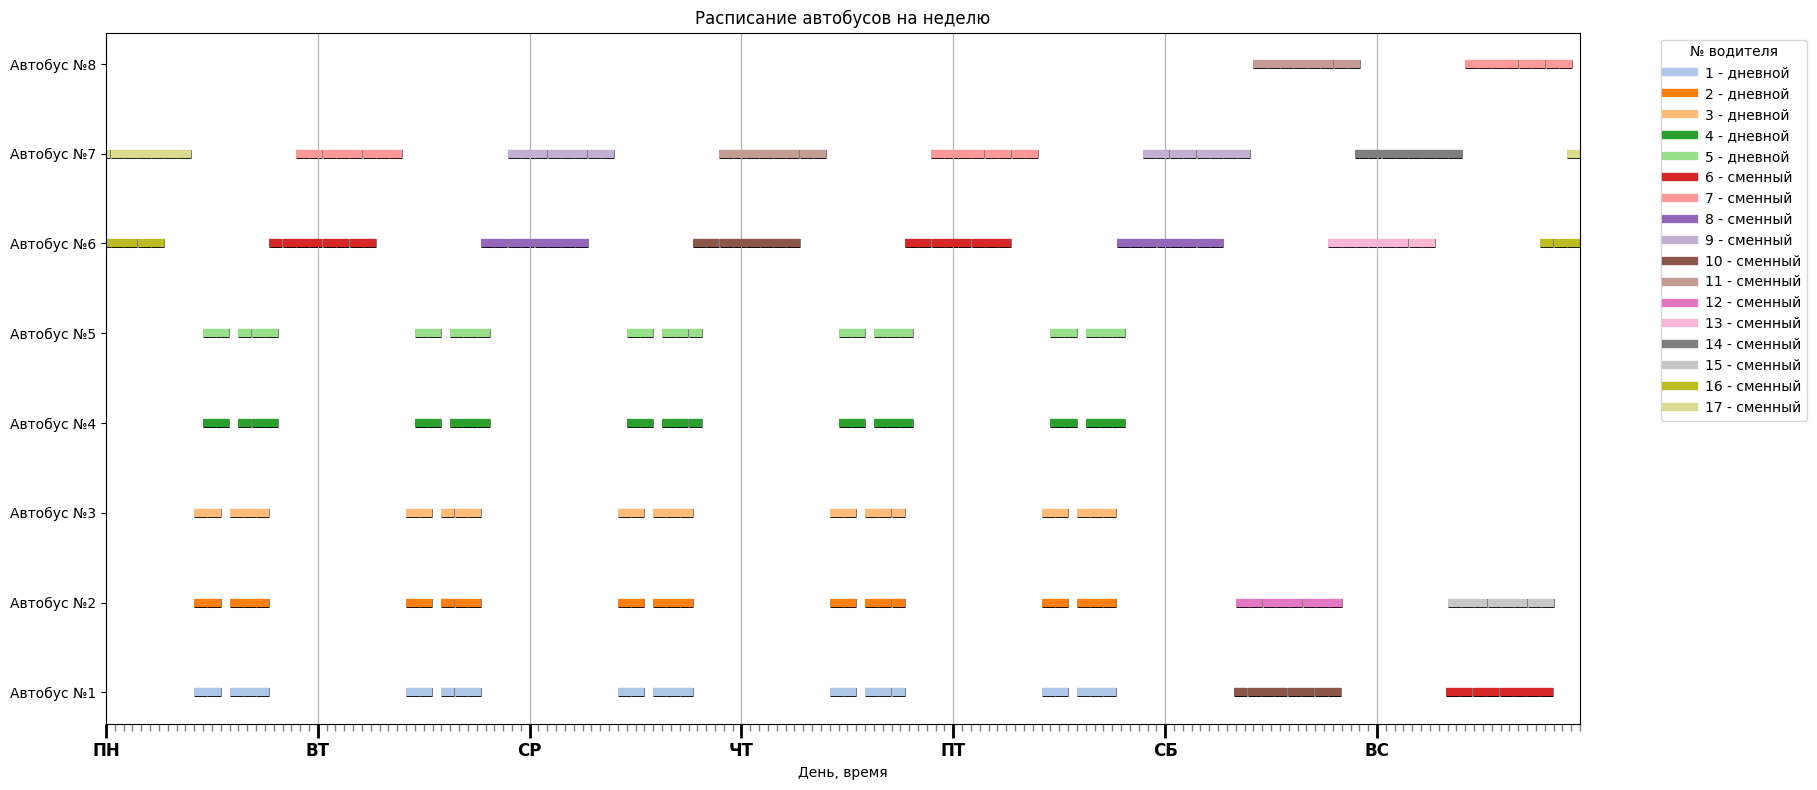

In [21]:
display_multiple_interval_trees_and_get_drivers(manual_schedule)

In [23]:
display_drivers(manual_schedule.driver_list)

,№,Тип,Понедельник,Вторник,Среда,Четверг,Пятница,Суббота,Воскресенье
0,Водитель 1,Дневной,10:00-18:29,10:00-18:29,10:00-18:29,10:00-18:29,10:00-18:29,,
1,Водитель 2,Дневной,10:00-18:29,10:00-18:29,10:00-18:29,10:00-18:29,10:00-18:29,,
2,Водитель 3,Дневной,10:00-18:29,10:00-18:29,10:00-18:29,10:00-18:29,10:00-18:29,,
3,Водитель 4,Дневной,11:00-19:29,11:00-19:29,11:00-19:29,11:00-19:29,11:00-19:29,,
4,Водитель 5,Дневной,11:00-19:29,11:00-19:29,11:00-19:29,11:00-19:29,11:00-19:29,,
5,Водитель 6,Сменный,18:30-06:59,,,18:30-06:59,,,07:50-20:19
6,Водитель 7,Сменный,21:30-09:59,,,21:30-09:59,,,10:00-22:29
7,Водитель 8,Сменный,,18:30-06:59,,,18:30-06:59,,
8,Водитель 9,Сменный,,21:30-09:59,,,21:30-09:59,,
9,Водитель 10,Сменный,,,18:30-06:59,,,07:50-20:19,
